In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
import scipy.linalg

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder


# Parameters -------------------------------------------------------------------------------

In [2]:
n_test = 100
n_train_max  = 1800  # this has to be larger than 4**n_qubits
n_qubits = 1
reps = 5

qubits_list = [2, 3]

In [3]:
import os

data_directory = f"Data/{n_qubits}_qubits"
# Ensure the directory exists
os.makedirs(f"./{data_directory}", exist_ok=True)

graph_directory = f"Graphs/{n_qubits}_qubits"
# Ensure the directory exists
os.makedirs(f"./{graph_directory}", exist_ok=True)

# Functions to generate data ---------------------------------------------------------------

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("Fashion-MNIST", version=1, return_X_y=True, as_frame=False)

# map data in [0,1] range
X = X / 255.0

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000, test_size=10000)

# standardize data -- make mean 0 and std 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# choose only two classes '0' and '1' for now
train_filter = np.where((y_train == '0') | (y_train == '1'))
test_filter = np.where((y_test == '0') | (y_test == '1'))

# reduced training and test data with only 2 classes
x_train_red, y_train_red = X_train[train_filter], y_train[train_filter]
x_test_red, y_test_red = X_test[test_filter], y_test[test_filter]

# Reshape labels to one-hot encode them
y_train_red = y_train_red.reshape(-1, 1)
y_test_red = y_test_red.reshape(-1, 1)

# One-hot encode the labels
ohe = OneHotEncoder()
ohe.fit(y_train_red)
y_train = ohe.transform(y_train_red).toarray()
ohe.fit(y_test_red)
y_test = ohe.transform(y_test_red).toarray()

# Define quantum kernel functions -------------------------------------------------------

In [5]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

def quantum_feature_map(x):
    """
    Feature map for quantum kernel.
    Adjust repetitions (reps) or gates if kernel is not full rank.
    """
    reps = n_qubits
    for r in range(reps):
        for i in range(len(x)):
            qml.RX(x[i], wires=i % n_qubits)
        for n in range(n_qubits - 1):
            qml.CNOT(wires=[n, n + 1])
        for i in range(len(x)):
            qml.RZ(x[i], wires=i % n_qubits)

dev_kernel = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev_kernel)
def kernel_state(x1):
    """
    Takes as input data and returns density matrix.
    Use this function to generate rho(X).
    """
    quantum_feature_map(x1)
    return qml.density_matrix(wires=range(n_qubits))

projector = np.zeros((2 ** n_qubits, 2 ** n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    quantum_feature_map(x1)
    qml.adjoint(quantum_feature_map)(x2)
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

In [6]:
# compute data matrix condition number and rank -------------------------------------------------------------------
@qml.qnode(dev_kernel)
def kernel_state(x1):
    """The quantum data encoding."""
    quantum_feature_map(x1)
    return qml.density_matrix(wires=range(n_qubits))

def compute_rank(A, tol=None):
    U, s, Vh = scipy.linalg.svd(A)
    if tol is None:
        tol = max(A.shape) * np.spacing(np.max(s))
    rank = np.sum(s > tol)
    return rank

# Do PCA

In [7]:
from sklearn.decomposition import PCA

# Initialize PCA with the number of components
to_use = 2 * n_qubits
pca = PCA(n_components=to_use)

# Fit the PCA model and transform the data
x_train = pca.fit_transform(x_train_red)
x_test = pca.transform(x_test_red)

# choose only subset of data
x_test = x_test[:n_test]
y_test = y_test[:n_test]

# loop over different number of train data -------------------------------------------------

In [8]:
mse_arr = [[] for _ in range(reps)]
mse_arr_train = [[] for _ in range(reps)]
eig_vals_arr = [[] for _ in range(reps)]
cond_no_arr = [[] for _ in range(reps)]
rank_arr = [[] for _ in range(reps)]
params = [[] for _ in range(reps)]
K_train_arr = []

for r in range(reps):

    x_train_max = x_train[r * n_train_max:(r + 1) * n_train_max]
    y_train_max = y_train[r * n_train_max:(r + 1) * n_train_max]

    if n_qubits == 1:
        limit_low, limit_up, step = 1, 8, 1
    elif n_qubits == 2:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 10, 2**(2 * n_qubits) + 11, 2
    elif n_qubits == 3:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 60, 2**(2 * n_qubits) + 61, 20
    elif n_qubits == 4:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 180, 2**(2 * n_qubits) + 181, 60
    elif n_qubits == 5:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 720, 2**(2 * n_qubits) + 721, 240

    for n_train in range(limit_low, limit_up, step):
        x_train_krr = x_train_max[:n_train]
        y_train_krr = y_train_max[:n_train]
        print(r + 1, ": train samples: ", x_train_krr.shape[0], "/", limit_up - 1)

        K_train = kernel_matrix(x_train_krr, x_train_krr).astype(np.float64)
        K_test = kernel_matrix(x_test, x_train_krr).astype(np.float64)
        K_train_arr.append(K_train)

        kernel_ridge_model = KernelRidge(kernel='precomputed', alpha=0.0)
        kernel_ridge_model.fit(K_train, y_train_krr)

        predictions = kernel_ridge_model.predict(K_test)
        train_predictions = kernel_ridge_model.predict(K_train)

        params[r].append(kernel_ridge_model.dual_coef_)

        K_eig_vals = np.linalg.eig(K_train)[0]
        cond_no = np.linalg.cond(K_train)
        rank = np.linalg.matrix_rank(K_train)

        eig_vals_arr[r].append(K_eig_vals)
        cond_no_arr[r].append(cond_no)
        rank_arr[r].append(rank)
        print("Rank of Kernel: ", rank)

        mse = mean_squared_error(np.real(y_test), predictions)
        mse_arr[r].append(mse)
        print("Mean Squared Error Test:", mse)

        train_mse = mean_squared_error(y_train_krr, train_predictions)
        mse_arr_train[r].append(train_mse)
        print("Mean Squared Error Train:", train_mse)
# compute data matrix condition number and rank -------------------------------------------------------------------
no_train = 2**(2*n_qubits)
cond_no_arr = []
rank_arr = []
for n in range(limit_low, limit_up, step):
    X = [kernel_state(x_train_max[m, :]).flatten().astype(np.complex128) for m in range(n)]
    cond_no = np.linalg.cond(X)
    cond_no_arr.append(cond_no)
    rank_arr.append(compute_rank(np.array(X)))


1 : train samples:  1 / 7
Rank of Kernel:  1
Mean Squared Error Test: 0.4152590611290098
Mean Squared Error Train: 0.0
1 : train samples:  2 / 7
Rank of Kernel:  2
Mean Squared Error Test: 0.47820784700460206
Mean Squared Error Train: 5.318132282721589e-32
1 : train samples:  3 / 7
Rank of Kernel:  3
Mean Squared Error Test: 0.5186966347058524
Mean Squared Error Train: 1.159846057614799e-31
1 : train samples:  4 / 7
Rank of Kernel:  4
Mean Squared Error Test: 0.4204803944427132
Mean Squared Error Train: 1.2745305394318482e-30
1 : train samples:  5 / 7


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  4
Mean Squared Error Test: 0.5044517892128668
Mean Squared Error Train: 0.00015076738358473098
1 : train samples:  6 / 7


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  4
Mean Squared Error Test: 1.2583222914180427
Mean Squared Error Train: 0.02237037327721831
1 : train samples:  7 / 7


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  4
Mean Squared Error Test: 0.4266609543051179
Mean Squared Error Train: 0.043696810991625624
2 : train samples:  1 / 7
Rank of Kernel:  1
Mean Squared Error Test: 0.41953196077385907
Mean Squared Error Train: 0.0
2 : train samples:  2 / 7
Rank of Kernel:  2
Mean Squared Error Test: 0.3596093765063222
Mean Squared Error Train: 1.5654827305711844e-32
2 : train samples:  3 / 7
Rank of Kernel:  3
Mean Squared Error Test: 0.38161557429637516
Mean Squared Error Train: 6.897901225898049e-32
2 : train samples:  4 / 7
Rank of Kernel:  4
Mean Squared Error Test: 50.02161788598417
Mean Squared Error Train: 4.2880259821048566e-27
2 : train samples:  5 / 7


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  4
Mean Squared Error Test: 3.0660880576574163
Mean Squared Error Train: 0.07213280988294085
2 : train samples:  6 / 7


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  4
Mean Squared Error Test: 0.336253708349456
Mean Squared Error Train: 0.08048190023877128
2 : train samples:  7 / 7


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  4
Mean Squared Error Test: 0.3385538623195913
Mean Squared Error Train: 0.06937187486592201
3 : train samples:  1 / 7
Rank of Kernel:  1
Mean Squared Error Test: 0.39840460927727767
Mean Squared Error Train: 2.465190328815662e-32
3 : train samples:  2 / 7
Rank of Kernel:  2
Mean Squared Error Test: 0.4118226922246903
Mean Squared Error Train: 0.0
3 : train samples:  3 / 7
Rank of Kernel:  3
Mean Squared Error Test: 0.7962591797418117
Mean Squared Error Train: 2.3610980593490842e-30
3 : train samples:  4 / 7
Rank of Kernel:  4
Mean Squared Error Test: 1.9387838638752046
Mean Squared Error Train: 2.489399268827622e-29
3 : train samples:  5 / 7


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  4
Mean Squared Error Test: 0.5761794338135418
Mean Squared Error Train: 0.008844288131847552
3 : train samples:  6 / 7


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  4
Mean Squared Error Test: 0.5822501245182858
Mean Squared Error Train: 0.00936065528012317
3 : train samples:  7 / 7


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  4
Mean Squared Error Test: 0.6923435664559048
Mean Squared Error Train: 0.02459986810903194
4 : train samples:  1 / 7
Rank of Kernel:  1
Mean Squared Error Test: 0.42042713847033475
Mean Squared Error Train: 0.0
4 : train samples:  2 / 7
Rank of Kernel:  2
Mean Squared Error Test: 0.45920974093143613
Mean Squared Error Train: 0.0
4 : train samples:  3 / 7
Rank of Kernel:  3
Mean Squared Error Test: 0.4551849468850936
Mean Squared Error Train: 8.217301096052206e-33
4 : train samples:  4 / 7
Rank of Kernel:  4
Mean Squared Error Test: 0.4528783102800039
Mean Squared Error Train: 1.9705292892946891e-31
4 : train samples:  5 / 7


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  4
Mean Squared Error Test: 0.49367978777792587
Mean Squared Error Train: 0.020333533747205132
4 : train samples:  6 / 7


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  4
Mean Squared Error Test: 0.4564455619215996
Mean Squared Error Train: 0.03344716230616965
4 : train samples:  7 / 7


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  4
Mean Squared Error Test: 0.45031776249936106
Mean Squared Error Train: 0.05454814776084893
5 : train samples:  1 / 7
Rank of Kernel:  1
Mean Squared Error Test: 0.3974795700482625
Mean Squared Error Train: 0.0
5 : train samples:  2 / 7
Rank of Kernel:  2
Mean Squared Error Test: 0.400228131085685
Mean Squared Error Train: 3.0814879110195774e-33
5 : train samples:  3 / 7
Rank of Kernel:  3
Mean Squared Error Test: 0.8950500797931121
Mean Squared Error Train: 3.353165042036147e-30
5 : train samples:  4 / 7
Rank of Kernel:  4
Mean Squared Error Test: 0.8916919876691272
Mean Squared Error Train: 1.1169194815798692e-29
5 : train samples:  5 / 7


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  4
Mean Squared Error Test: 0.6637324152169335
Mean Squared Error Train: 0.022618297522907026
5 : train samples:  6 / 7


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  4
Mean Squared Error Test: 0.32309313292545117
Mean Squared Error Train: 0.1412961242231091
5 : train samples:  7 / 7
Rank of Kernel:  4
Mean Squared Error Test: 0.4275475043085487
Mean Squared Error Train: 0.13035096133321883


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


# Save the data:

In [9]:
import pickle

# Creating a dictionary to store all the arrays
data = {
    'mse_arr': mse_arr,
    'mse_arr_train': mse_arr_train,
    'eig_vals_arr': eig_vals_arr,
    'cond_no_arr': cond_no_arr,
    'rank_arr': rank_arr,
    'params': params,
    'K_train_arr': K_train_arr
}

# Saving the dictionary to a file using pickle
with open(f'./{data_directory}/data_nqubits_{n_qubits}.pkl', 'wb') as f:
    pickle.dump(data, f)


# Load the data

In [10]:
# import pickle

# # Loading the data from the pickle file
# with open('data.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)

# # Access the arrays after loading
# mse_arr = loaded_data['mse_arr']
# mse_arr_train = loaded_data['mse_arr_train']
# eig_vals_arr = loaded_data['eig_vals_arr']
# cond_no_arr = loaded_data['cond_no_arr']
# rank_arr = loaded_data['rank_arr']
# params = loaded_data['params']
# K_train_arr = loaded_data['K_train_arr']


# compute mse for varying number of train samples -------------

In [11]:
mse_arr = np.array(mse_arr)
mse_mean = np.mean(mse_arr, axis=0, dtype=np.float64)
mse_std = np.std(mse_arr, axis=0) / np.log(10)

mse_mean_train = np.mean(mse_arr_train, axis=0)
mse_std_train = np.std(mse_arr_train, axis=0)

# save all files -------------------------------------------------------------------
np.savetxt(f"./{data_directory}/mse_mean_nqubits_{n_qubits}_MNIST_Fashion", [mse_mean], newline='')
np.savetxt(f"./{data_directory}/mse_std_nqubits_{n_qubits}_MNIST_Fashion", [mse_std], newline='')
np.savetxt(f"./{data_directory}/mse_mean_train_nqubits_{n_qubits}_MNIST_Fashion", [mse_mean_train], newline='')
np.savetxt(f"./{data_directory}/mse_std_train_nqubits_{n_qubits}_MNIST_Fashion", [mse_std_train], newline='')
np.savetxt(f"./{data_directory}/arrange_nqubits_{n_qubits}_MNIST_Fashion", [np.arange(limit_low, limit_up, step)], newline='')
np.savetxt(f"./{data_directory}/rank_arr_nqubits_{n_qubits}MNIST_Fashion", [rank_arr], newline='')
np.savetxt(f"./{data_directory}/cond_no_arr_nqubits_{n_qubits}MNIST_Fashion", [cond_no_arr], newline='')

In [12]:
mse_arr.shape

(5, 7)

In [13]:
mse_mean

array([ 0.41022047,  0.42181556,  0.60936128, 10.74509049,  1.0608263 ,
        0.59127296,  0.46708473])

In [14]:
np.arange(limit_low, limit_up, step)/4**n_qubits

array([0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75])

In [15]:
len(np.arange(limit_low, limit_up, step)/4**n_qubits)

7

In [16]:
len(mse_mean)

7

# Plotting

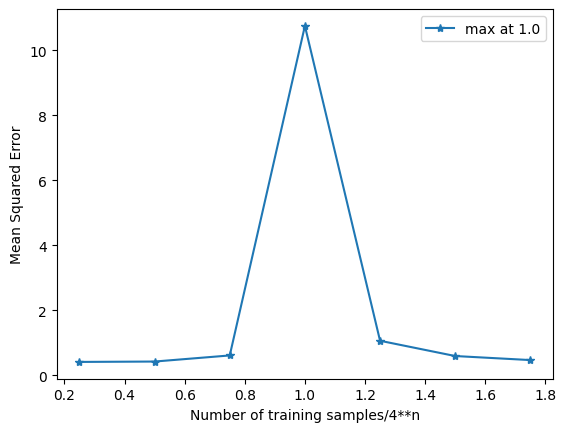

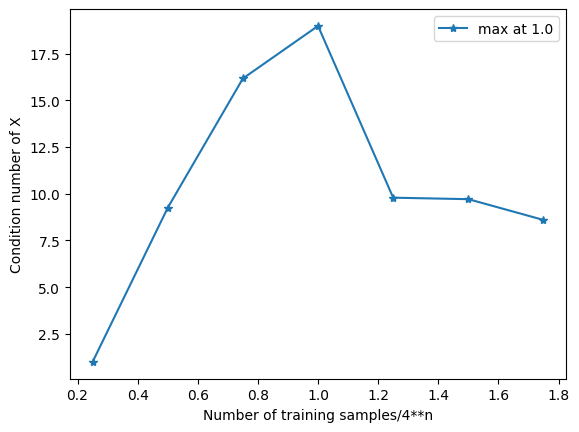

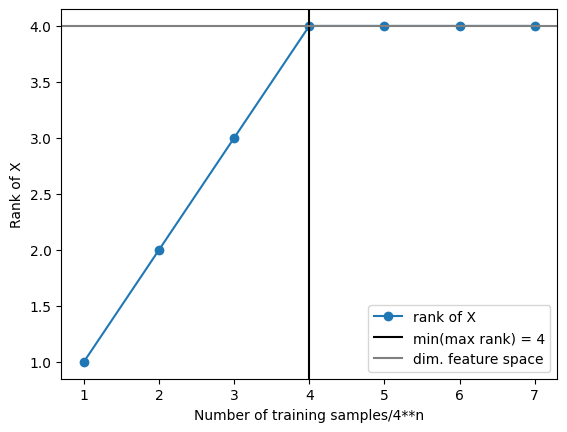

4 /  4


In [17]:
import matplotlib.pyplot as plt

# Plotting Test MSE
scenario = f"MNIST_Fashion_nqubits_{n_qubits}"
plt.plot(np.arange(limit_low, limit_up, step)/4**n_qubits, mse_mean, label=f"max at {range(limit_low, limit_up, step)[np.argmax(mse_mean)]/4**n_qubits}", marker="*")
plt.legend()
plt.xlabel("Number of training samples/4**n")
plt.ylabel("Mean Squared Error")
plt.savefig(f"./{graph_directory}/{scenario}_MSE.png", dpi=500, bbox_inches='tight')
plt.show()

# Plotting condition number of kernel matrix
plt.plot(np.arange(limit_low, limit_up, step)/4**n_qubits, cond_no_arr, label=f"max at {range(limit_low, limit_up, step)[np.argmax(cond_no_arr)]/4**n_qubits}", marker="*")
plt.legend()
plt.xlabel("Number of training samples/4**n")
plt.ylabel("Condition number of X")
plt.savefig(f"./{graph_directory}/{scenario}_cond_no_arr.png", dpi=500, bbox_inches='tight')
plt.show()

# Plotting Rank  of kernel matrix
plt.plot(np.arange(limit_low, limit_up, step), rank_arr, label="rank of X", marker="o")
plt.axvline(range(limit_low, limit_up, step)[np.min(np.where(np.array(rank_arr) == np.max(np.array(rank_arr))))], label=f"min(max rank) = {range(limit_low, limit_up, step)[np.min(np.where(np.array(rank_arr) == np.max(np.array(rank_arr))))]}", color="black")
plt.axhline(no_train, color="grey", label="dim. feature space")
plt.legend()
plt.xlabel("Number of training samples/4**n")
plt.ylabel("Rank of X")
plt.savefig(f"./{graph_directory}/{scenario}_rank_arr.png", dpi=500, bbox_inches='tight')
plt.show()

rank = np.linalg.matrix_rank(X)
print(rank, "/ ", no_train)
